<h2 align='center'><a>1.Understanding the business problem</h2>


#### Objective: The objective is predicting store sales using historical markdown data.

<h2 align='center'><a>2.Exploratory Data Analysis(EDA)</h2>

#### <a>Importing the necessary library.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import pandas_profiling 

from datetime import datetime

import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#### <a>Import the data

In [4]:
train = pd.read_csv('/Users/anish/Desktop/Analytix labs/CASE STUDIES/Python Final/2. Walmart Store Sales Forecasting/data/train.csv')
feature = pd.read_csv('/Users/anish/Desktop/Analytix labs/CASE STUDIES/Python Final/2. Walmart Store Sales Forecasting/data/features.csv')
test = pd.read_csv('/Users/anish/Desktop/Analytix labs/CASE STUDIES/Python Final/2. Walmart Store Sales Forecasting/data/test.csv')
stores = pd.read_csv('/Users/anish/Desktop/Analytix labs/CASE STUDIES/Python Final/2. Walmart Store Sales Forecasting/data/stores.csv')
sampleSubmission =pd.read_csv('/Users/anish/Desktop/Analytix labs/CASE STUDIES/Python Final/2. Walmart Store Sales Forecasting/data/sampleSubmission.csv')


#### Merging the DataSet 
##### -(train+Store+Feature) &  -(test+Store+Feature)

In [5]:
train_ts = pd.merge(train,stores)  ##Merging the Dataset (train+Store+Feature)
train = pd.merge(train_ts,feature)

#############

test_ts = pd.merge(test,stores)  ##Merging the Dataset (test+Store+Feature)
test= pd.merge(test_ts,feature)

In [6]:
train.head(2)          

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [7]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null object
IsHoliday       115064 non-null bool
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             76902 non-null float64
Unemployment    76902 non-null float64
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


#### <a>Creating Data audit Report

#### Create UDF

In [10]:
# Use a general function that returns multiple values-

# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                        x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [11]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [12]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

#### DATA INSPECTION

#### <a>Making friendship with data after importing.

##### 1. Training Data

In [13]:
# seperate categorical and continuous variables
train_conti_vars = train.loc[:, (train.dtypes == 'float64') | (train.dtypes == 'int64')]
train_cat_vars = train.loc[:, (train.dtypes == 'object')|(train.dtypes == 'bool')]

In [14]:
#checking P1 & Min(Outliers),P99 & Max(Outliers),Mean Median,NMISS(for missing values).

train_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,421570.0,0.0,9.359084e+06,22.20,22.00,12.79,1.634600e+02,1.00,1.00,3.00,5.00,11.00,22.00,33.00,40.00,43.00,45.00,45.00
Dept,421570.0,0.0,1.865882e+07,44.26,37.00,30.49,9.297700e+02,1.00,1.00,4.00,7.00,18.00,37.00,74.00,92.00,95.00,98.00,99.00
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.26,7612.03,22711.18,5.157979e+08,-4988.94,5.00,59.97,291.10,2079.65,7612.03,20205.85,42845.67,61201.95,106479.59,693099.36
Size,421570.0,0.0,5.764039e+10,136727.92,140167.00,60980.58,3.718632e+09,34875.00,34875.00,39690.00,39910.00,93638.00,140167.00,202505.00,204184.00,206302.00,219622.00,219622.00
Temperature,421570.0,0.0,2.533217e+07,60.09,62.09,18.45,3.403300e+02,-2.06,18.30,27.31,33.98,46.68,62.09,74.28,83.58,87.27,92.81,100.14
Fuel_Price,421570.0,0.0,1.416908e+06,3.36,3.45,0.46,2.100000e-01,2.47,2.56,2.65,2.72,2.93,3.45,3.74,3.92,4.03,4.20,4.47
MarkDown1,150681.0,270889.0,1.091898e+09,7246.42,5347.45,8291.22,6.874435e+07,0.27,17.76,149.19,375.20,2240.27,5347.45,9210.90,15282.47,21801.35,41524.03,88646.76
MarkDown2,111248.0,310322.0,3.709708e+08,3334.63,192.00,9475.36,8.978240e+07,-265.76,-0.99,1.95,6.98,41.60,192.00,1926.94,8549.74,16497.47,50366.60,104519.54
MarkDown3,137091.0,284479.0,1.973317e+08,1439.42,24.60,9623.08,9.260364e+07,-29.10,0.06,0.65,1.65,5.08,24.60,103.99,400.09,1059.90,63143.29,141630.61
MarkDown4,134967.0,286603.0,4.566161e+08,3383.17,1481.31,6292.38,3.959410e+07,0.22,3.97,28.76,108.71,504.22,1481.31,3595.04,7871.42,12645.96,35785.26,67474.85


In [15]:
#checking Mode,Freq,NMISS,Percent,Count.

train_cat_vars.apply(categorical_var_summary).T.round(2)

,N,NMISS,MODE,FREQ,PERCENT
Date,421570,0,2011-12-23,3027,0.72
IsHoliday,421570,0,False,391909,92.96
Type,421570,0,A,215478,51.11


##### 2. Testing Data

In [16]:
# seperate categorical and continuous variables
test_conti_vars = test.loc[:, (test.dtypes == 'float64') | (test.dtypes == 'int64')]
test_cat_vars = test.loc[:, (test.dtypes == 'object')|(test.dtypes == 'bool')]

In [17]:
#checking P1 & Min(Outliers),P99 & Max(Outliers),Mean Median,NMISS(for missing values).

test_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,115064.0,0.0,2.558817e+06,22.24,22.00,12.81,1.640900e+02,1.00,1.00,3.00,5.00,11.00,22.00,33.00,40.00,43.00,45.00,45.00
Dept,115064.0,0.0,5.101883e+06,44.34,37.00,30.66,9.398200e+02,1.00,1.00,4.00,7.00,18.00,37.00,74.00,92.00,95.00,98.00,99.00
Size,115064.0,0.0,1.570597e+10,136497.69,140167.00,61106.93,3.734056e+09,34875.00,34875.00,39690.00,39910.00,93638.00,140167.00,202505.00,204184.00,206302.00,219622.00,219622.00
Temperature,115064.0,0.0,6.206760e+06,53.94,54.47,18.72,3.505900e+02,-7.29,11.44,23.98,29.97,39.82,54.47,67.35,79.48,83.82,92.14,101.95
Fuel_Price,115064.0,0.0,4.121070e+05,3.58,3.61,0.24,6.000000e-02,2.87,2.96,3.16,3.23,3.43,3.61,3.77,3.87,3.95,4.08,4.12
MarkDown1,114915.0,149.0,8.836063e+08,7689.22,4842.29,10698.76,1.144635e+08,-2781.45,20.84,189.49,457.66,1966.46,4842.29,9439.14,15325.04,23140.88,65757.57,103184.98
MarkDown2,86437.0,28627.0,3.227602e+08,3734.05,742.59,8323.50,6.928057e+07,-35.74,0.02,6.14,25.77,180.35,742.59,2735.67,9277.29,22671.67,42920.21,71074.17
MarkDown3,105235.0,9829.0,2.528890e+08,2403.09,78.26,13767.94,1.895562e+08,-179.26,0.15,1.18,3.10,15.10,78.26,272.58,698.93,2361.57,86476.66,149483.31
MarkDown4,102176.0,12888.0,3.429250e+08,3356.22,840.94,7570.50,5.731249e+07,0.22,2.61,16.96,37.36,155.46,840.94,3096.92,7674.41,14191.01,44739.28,65344.64
MarkDown5,115064.0,0.0,4.513594e+08,3922.68,2390.43,19445.15,3.781139e+08,-185.17,269.30,540.89,770.88,1309.30,2390.43,4227.27,6966.34,9316.71,18599.30,771448.10


In [18]:
#checking Mode,Freq,NMISS,Percent,Count.

test_cat_vars.apply(categorical_var_summary).T.round(2)

,N,NMISS,MODE,FREQ,PERCENT
Date,115064,0,2012-12-21,3002,2.61
IsHoliday,115064,0,False,106136,92.24
Type,115064,0,A,58713,51.03


In [19]:
#pandas_profiling.ProfileReport(train)

In [20]:
#pandas_profiling.ProfileReport(test)

###### Correlation

In [21]:
train_corr=pd.DataFrame(train.corr())

train_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238


In [22]:
test_corr=pd.DataFrame(test.corr())
test_corr.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.309614,0.157526,0.050088,0.155448,0.103681,-0.002916,-0.001988
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136


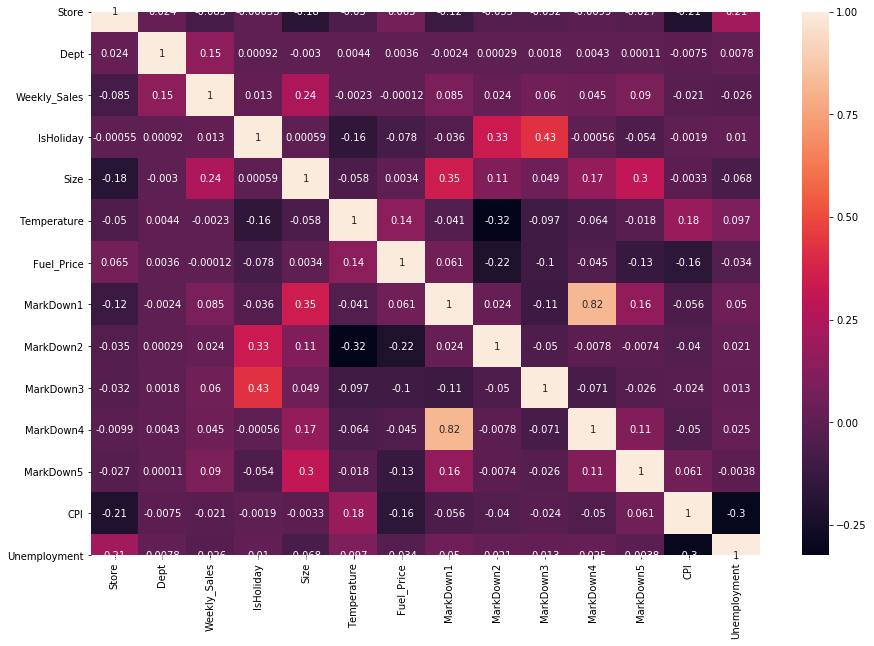

In [23]:
# visualize correlation matrix in Seaborn using a heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train.corr(),annot=True,ax=ax)

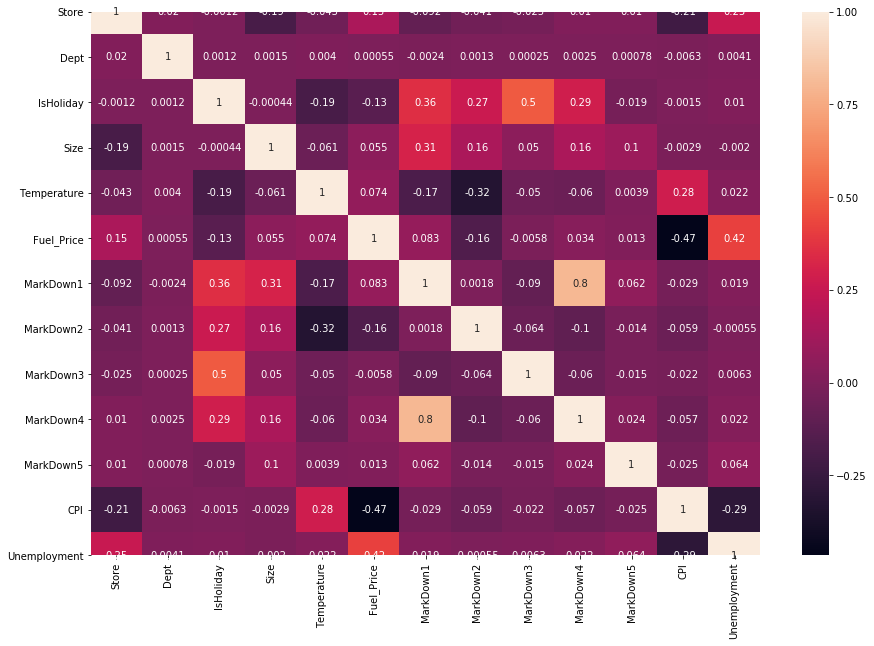

In [24]:
# visualize correlation matrix in Seaborn using a heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(test.corr(),annot=True,ax=ax)

#### -Markdowns are Highly Correlated.

#### -Markdown 4 is  Highly Correlated to Markdown 1

### <a>Data Exploratory Analysis

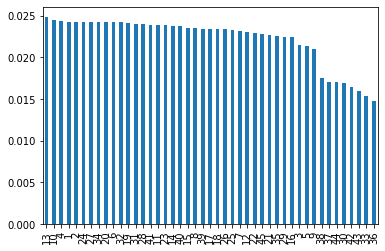

In [25]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

#### -The above graph shows that Highest number of Store-Store 13 and Lowest number of Store-Store 36

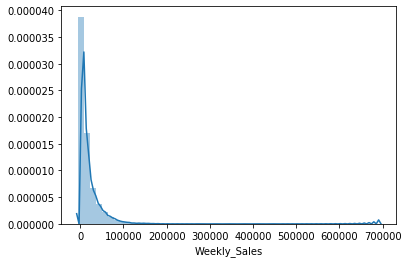

In [26]:
sns.distplot(train.Weekly_Sales)

###### Store Size vs Sales

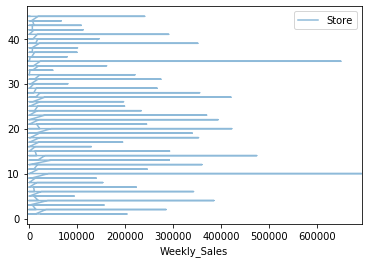

In [27]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

<big> From this plot, we notice that Store 10 has the highest Sales

###### Sales vs Type

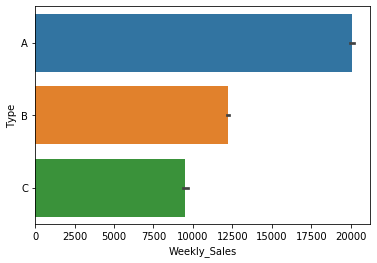

In [28]:
#tips = sns.load_dataset('train')
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

<big> From this plot, we notice that 'type C' stores have fewer sales and 'type A' stores have more sales in general.

###### Sales vs Deptartment

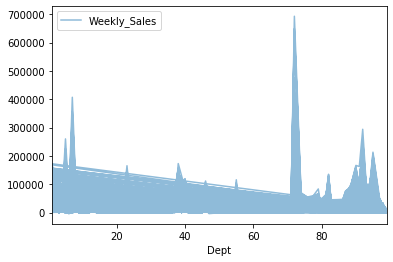

In [29]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,fig=(4,5))

<big> From this plot, we notice Deptartment with the highest sales lies between Dept 60 and 80

____

#### <a>Rearranging order of test & train

In [30]:
train=train[['Date','Store', 'Dept', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Weekly_Sales']]

In [31]:
test=test[['Date','Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment']]

In [32]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#### Properly treating the Markdown with imputing Nan equal to zero.

In [33]:
train[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']]=train[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0)
test[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']]=test[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0)

In [34]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

In [35]:
## Converting True & False in-Isholdays columns int i.e 1 and 0
train['IsHoliday']=train['IsHoliday'].astype('int64')

test['IsHoliday']=test['IsHoliday'].astype('int64')

In [36]:
train[['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4','MarkDown5', 'CPI', 'Unemployment', 'Weekly_Sales']]=train[['Store', 'Dept', 'IsHoliday', 'Size',
                                                                               'Temperature','Fuel_Price', 'MarkDown1',
                                                                               'MarkDown2', 'MarkDown3', 'MarkDown4',
                                                                               'MarkDown5', 'CPI', 'Unemployment', 
                                                                               'Weekly_Sales']].astype('int32')

test[['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4','MarkDown5', 'CPI', 'Unemployment']]=test[['Store', 'Dept', 'IsHoliday', 'Size',
                                                                               'Temperature','Fuel_Price', 'MarkDown1',
                                                                               'MarkDown2', 'MarkDown3', 'MarkDown4',
                                                                               'MarkDown5', 'CPI', 'Unemployment']].astype('int32')

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Date            421570 non-null datetime64[ns]
Store           421570 non-null int32
Dept            421570 non-null int32
IsHoliday       421570 non-null int32
Type            421570 non-null object
Size            421570 non-null int32
Temperature     421570 non-null int32
Fuel_Price      421570 non-null int32
MarkDown1       421570 non-null int32
MarkDown2       421570 non-null int32
MarkDown3       421570 non-null int32
MarkDown4       421570 non-null int32
MarkDown5       421570 non-null int32
CPI             421570 non-null int32
Unemployment    421570 non-null int32
Weekly_Sales    421570 non-null int32
dtypes: datetime64[ns](1), int32(14), object(1)
memory usage: 52.2+ MB


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Date            115064 non-null datetime64[ns]
Store           115064 non-null int32
Dept            115064 non-null int32
IsHoliday       115064 non-null int32
Type            115064 non-null object
Size            115064 non-null int32
Temperature     115064 non-null int32
Fuel_Price      115064 non-null int32
MarkDown1       115064 non-null int32
MarkDown2       115064 non-null int32
MarkDown3       115064 non-null int32
MarkDown4       115064 non-null int32
MarkDown5       115064 non-null int32
CPI             115064 non-null int32
Unemployment    115064 non-null int32
dtypes: datetime64[ns](1), int32(13), object(1)
memory usage: 8.3+ MB


In [39]:
train.head()

,Date,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
0,2010-02-05,1,1,0,A,151315,42,2,0,0,0,0,0,211,8,24924
1,2010-02-05,1,2,0,A,151315,42,2,0,0,0,0,0,211,8,50605
2,2010-02-05,1,3,0,A,151315,42,2,0,0,0,0,0,211,8,13740
3,2010-02-05,1,4,0,A,151315,42,2,0,0,0,0,0,211,8,39954
4,2010-02-05,1,5,0,A,151315,42,2,0,0,0,0,0,211,8,32229


In [40]:
test.head()

,Date,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,2012-11-02,1,1,0,A,151315,55,3,6766,5147,50,3639,2737,223,6
1,2012-11-02,1,2,0,A,151315,55,3,6766,5147,50,3639,2737,223,6
2,2012-11-02,1,3,0,A,151315,55,3,6766,5147,50,3639,2737,223,6
3,2012-11-02,1,4,0,A,151315,55,3,6766,5147,50,3639,2737,223,6
4,2012-11-02,1,5,0,A,151315,55,3,6766,5147,50,3639,2737,223,6


###### Outlier Treatment

In [41]:
###Outlier Treatment
train[['Weekly_Sales']]= train[['Weekly_Sales']].apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))


#### Missing Value -

In [42]:
print(train.isnull().sum())
print("*"*25)
print(test.isnull().sum())

Date            0
Store           0
Dept            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Weekly_Sales    0
dtype: int64
*************************
Date            0
Store           0
Dept            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


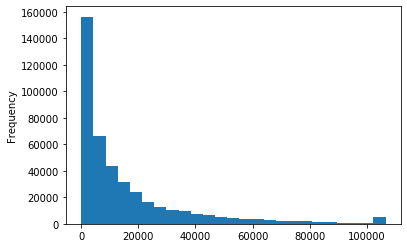

In [43]:
train.Weekly_Sales.plot.hist(bins=25)

_______________

### Feature Extraction
In this section, we select the appropriate features to train our classifier. Here, we create new features based on existing features. We also convert categorical features into numeric form.

###### Date Feature

In [44]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day 

In [45]:
print(train.Type.value_counts())
print("*"*30)
print(test.Type.value_counts())

A    215478
B    163495
C     42597
Name: Type, dtype: int64
******************************
A    58713
B    44500
C    11851
Name: Type, dtype: int64


In [46]:
print(train.IsHoliday.value_counts())
print("*"*30)
print(test.IsHoliday.value_counts())

0    391909
1     29661
Name: IsHoliday, dtype: int64
******************************
0    106136
1      8928
Name: IsHoliday, dtype: int64


In [47]:
train_test_data = [train, test]

    Converting Categorical Variable 'Type' into Numerical Variable 
    For A=1 , B=2, C=3

In [48]:
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

Making New Holiday Variable Based on Given Data....

In [49]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)
#........................................................................
test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)


In [50]:
# Altering the isHoliday value depending on these new holidays...
train['IsHoliday']=train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday']=test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

In [51]:
print(train.Christmas.value_counts())
print(train.Super_Bowl.value_counts())
print(train.Thanksgiving.value_counts())
print(train.Labour_Day.value_counts())

0    415624
1      5946
Name: Christmas, dtype: int64
0    412675
1      8895
Name: Super_Bowl, dtype: int64
0    415611
1      5959
Name: Thanksgiving, dtype: int64
0    412709
1      8861
Name: Labour_Day, dtype: int64


In [52]:
print(test.Christmas.value_counts())
print(test.Super_Bowl.value_counts())
print(test.Thanksgiving.value_counts())
print(test.Labour_Day.value_counts())

0    112076
1      2988
Name: Christmas, dtype: int64
0    112100
1      2964
Name: Super_Bowl, dtype: int64
0    112088
1      2976
Name: Thanksgiving, dtype: int64
0    115064
Name: Labour_Day, dtype: int64


In [53]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant..
# Droping the Extra holiday variables because its redundant..
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

### Feature Selection

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Date              421570 non-null datetime64[ns]
Store             421570 non-null int32
Dept              421570 non-null int32
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int32
Temperature       421570 non-null int32
Fuel_Price        421570 non-null int32
MarkDown1         421570 non-null int32
MarkDown2         421570 non-null int32
MarkDown3         421570 non-null int32
MarkDown4         421570 non-null int32
MarkDown5         421570 non-null int32
CPI               421570 non-null int32
Unemployment      421570 non-null int32
Weekly_Sales      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(1), int32(12), int64(6)
memory usage: 68.2 

####    Droping irrevelent variable:
    -Since we have imputed markdown variables therefore we will not be removing the all markdown variables.
    -Removing MarkDown5 because its Highly Skewed

In [55]:
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [56]:
train.head(2)

,Date,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Weekly_Sales,Date_dayofweek,Date_month,Date_year,Date_day
0,2010-02-05,1,1,0,1,151315,42,2,0,0,0,0,24924.0,4,2,2010,5
1,2010-02-05,1,2,0,1,151315,42,2,0,0,0,0,50605.0,4,2,2010,5


In [57]:
test.head(2)

,Date,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,2012-11-02,1,1,0,1,151315,55,3,6766,5147,50,3639,4,11,2012,2
1,2012-11-02,1,2,0,1,151315,55,3,6766,5147,50,3639,4,11,2012,2


In [58]:
# Converting all float var int integer..
#for var in train:
#    if train[var].dtypes == float:
#        train[var]=train[var].astype(int)
        
#for var in test:
#    if test[var].dtypes == float:
#test[var]=test[var].astype(int)

____

### Classification & Accuracy
    Define training and testing set

In [59]:
#### train X= Exery thing except Weekly_Sales
train_X=train.drop(['Weekly_Sales','Date'], axis=1)

#### train Y= Only Weekly_Sales 
train_y=train['Weekly_Sales'] 
test_X=test.drop('Date',axis=1).copy()

train_X.shape, train_y.shape, test_X.shape

((421570, 15), (421570,), (115064, 15))

### Building models & comparing their RMSE values

#### 1.Linear Regression

In [60]:
## Methood 1..
clf = LinearRegression()
clf.fit(train_X, train_y)
y_pred_linear=clf.predict(test_X)
acc_linear=round( clf.score(train_X, train_y) * 100, 2)
print ('scorbe:'+str(acc_linear) + ' percent')

scorbe:8.87 percent


#### 2. Random Forest

In [61]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100, 2)
print("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



#### 3. Decision Tree

In [62]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_dt = round( clf.score(train_X, train_y) * 100, 2)
print(str(acc_dt) + ' percent')

100.0 percent


#### Comparing Models
Let's compare the accuracy score of all the regression models used above.

In [63]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree'],
    
    'Score': [acc_linear, acc_rf,acc_dt]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,100.00
1,Random Forest,99.77
0,Linear Regression,8.87


**Predicting Sales value for test data based on highest score model.**

In [64]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })

submission.to_csv('weekly_sales predicted.csv', index=False)

In [65]:
submission.head()

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,31569.48
1,1_2_2012-11-02,47818.60
2,1_3_2012-11-02,11791.34
3,1_4_2012-11-02,37837.70
4,1_5_2012-11-02,31437.14


    ************* THE END **************************************************************************************************